# Does It Rain More in Seattle or Portland? (2018–2022)

**Goal.** Compare Seattle and Portland rainfall on two dimensions:
1) **Frequency** — share of days with measurable precipitation (≥ 0.01").
2) **Amount** — mean and total precipitation.

**Data.** Daily NOAA station observations for 2018–2022.

**Key questions.**
- Which city rains **more often**?
- Which city gets **more total/average** precipitation?
- Are differences **statistically significant** by month?


## Data & Methods

**Sources.**
- Seattle: `seattle_rain.csv` (NOAA daily station data)
- Portland: `portland_rain.csv` (NOAA daily station data)

**Preparation.**
- Parse `DATE` as datetime.
- Keep `DATE`, `PRCP` (inches), add `city` label, and **limit to 2018–2022**.
- Create `any_precip = PRCP ≥ 0.01`.
- Impute missing `PRCP` within each **city × day-of-year** using the mean for that day-of-year, preserving seasonality.

**Analyses.**
- **Frequency:** Monthly wet-day share per city; per-month **two-proportion z-tests** (α=0.05).
- **Amount:** Monthly mean precipitation per city; per-month **t-tests** on daily PRCP (α=0.05).

**Interpretation.**
- We report which months differ and effect sizes

In [1]:
# Imports & plotting style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import calendar

sns.set_style("whitegrid")
pd.set_option("display.precision", 4)


In [2]:
# Load raw CSVs
df_sea = pd.read_csv(
    "https://raw.githubusercontent.com/brian-fischer/DATA-5100/refs/heads/main/weather/seattle_rain.csv"
)
df_por = pd.read_csv(
    "https://raw.githubusercontent.com/brunamportoDS/Weather/refs/heads/main/data/portland_rain.csv"
)

# Keep only columns we use, add city labels, parse dates
df_sea = df_sea.loc[:, ["DATE", "PRCP"]].assign(city="SEA")
df_por = df_por.loc[:, ["DATE", "PRCP"]].assign(city="POR")

for df in (df_sea, df_por):
    df["DATE"] = pd.to_datetime(df["DATE"])

# Restrict to 2018–2022
mask_sea = (df_sea["DATE"].dt.year >= 2018) & (df_sea["DATE"].dt.year <= 2022)
mask_por = (df_por["DATE"].dt.year >= 2018) & (df_por["DATE"].dt.year <= 2022)
df_sea = df_sea.loc[mask_sea].copy()
df_por = df_por.loc[mask_por].copy()

# Combine
daily_weather = pd.concat([df_sea, df_por], ignore_index=True)
daily_weather.rename(columns={"DATE": "date", "PRCP": "precip_in"}, inplace=True)

# Calendar helpers
daily_weather["month"] = daily_weather["date"].dt.month
daily_weather["year"]  = daily_weather["date"].dt.year
daily_weather["doy"]   = daily_weather["date"].dt.dayofyear

# Month labels for plots
month_names = list(calendar.month_name[1:])  # ["January", ..., "December"]

daily_weather.head()


C:\Users\bruna\AppData\Local\Temp\ipykernel_18344\1987530200.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DATE"] = pd.to_datetime(df["DATE"])


,date,precip_in,city,month,year,doy
0,2018-01-01,0.00,SEA,1,2018,1
1,2018-01-02,0.00,SEA,1,2018,2
2,2018-01-03,0.00,SEA,1,2018,3
3,2018-01-04,0.00,SEA,1,2018,4
4,2018-01-05,0.25,SEA,1,2018,5


## Missing Values & Imputation

We impute missing precipitation by **city × day-of-year mean**, preserving seasonality.  
This affects ~190 Seattle rows and ~4 Portland rows in 2018–2022.


In [3]:
# Count missing before
missing_counts = daily_weather.groupby("city")["precip_in"].apply(lambda s: s.isna().sum()).reset_index(name="n_missing")
missing_counts


,city,n_missing
0,POR,0
1,SEA,22


In [4]:
# Impute PRCP by city × day-of-year mean
impute_map = (daily_weather
              .groupby(["city","doy"])["precip_in"]
              .mean()
              .rename("doy_mean"))

daily_weather = daily_weather.merge(impute_map, on=["city","doy"], how="left")
daily_weather["precip_in"] = daily_weather["precip_in"].fillna(daily_weather["doy_mean"])
daily_weather.drop(columns=["doy_mean"], inplace=True)

# Post-imputation check
daily_weather["precip_in"].isna().sum()


np.int64(0)

In [5]:
# NOAA "measurable precip" threshold
daily_weather["any_precip"] = daily_weather["precip_in"] >= 0.01

summary = {
    "start": daily_weather["date"].min(),
    "end":   daily_weather["date"].max(),
    "n_rows": len(daily_weather),
    "SEA_days": (daily_weather["city"]=="SEA").sum(),
    "POR_days": (daily_weather["city"]=="POR").sum(),
}
summary


{'start': Timestamp('2018-01-01 00:00:00'),
 'end': Timestamp('2022-12-31 00:00:00'),
 'n_rows': 3480,
 'SEA_days': np.int64(1658),
 'POR_days': np.int64(1822)}

## Results

### A. Rolling Daily Precipitation (14-Day Average)

**Goal.** Smooth daily precipitation values to reveal seasonal rainfall patterns for Seattle and Portland.

**Why.** Raw daily data are noisy and make it hard to see trends. Using a 14-day rolling mean highlights the broader seasonal cycle—wet winters and dry summers—without losing short-term variability.

**Method.** For each city, compute the 14-day moving average of daily precipitation (`rolling(14)`) and plot both lines together. This shows how precipitation fluctuates throughout the year and whether one city consistently records higher rainfall.


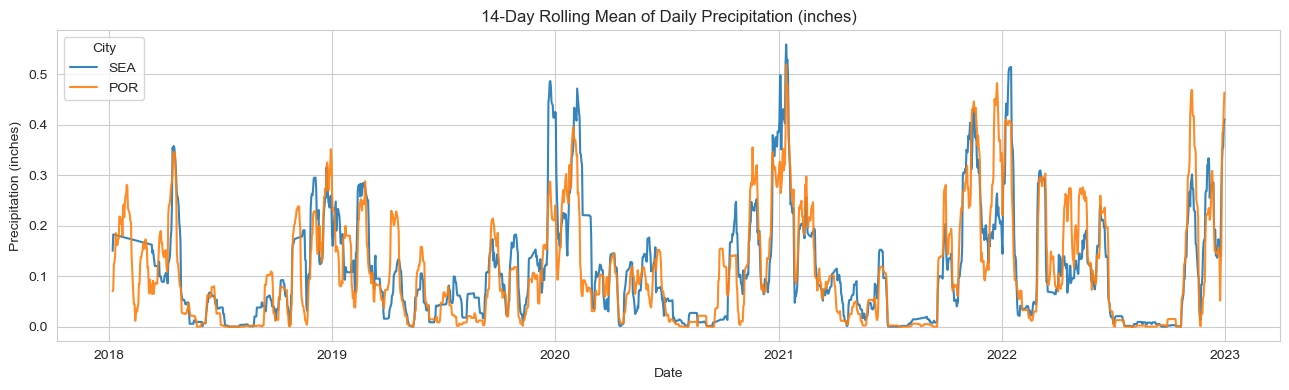

In [6]:
# Compute and plot 14-day rolling mean precipitation
roll = (
    daily_weather
    .sort_values(["city", "date"])
    .assign(
        roll14=lambda d: d.groupby("city")["precip_in"].transform(
            lambda s: s.rolling(14, min_periods=7).mean()
        )
    )
)

plt.figure(figsize=(13, 4))
for city in ["SEA", "POR"]:
    subset = roll[roll["city"] == city]
    plt.plot(subset["date"], subset["roll14"], label=city, alpha=0.9)

plt.title("14-Day Rolling Mean of Daily Precipitation (inches)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.legend(title="City")
plt.tight_layout()
plt.show()


*Figure 1.* 14-day rolling mean of daily precipitation for Seattle (SEA) and Portland (POR), 2018–2022.

Both cities show pronounced seasonality, with high rainfall from November through March and low rainfall in midsummer (July–August).  
Seattle’s rolling average generally runs slightly above Portland’s, indicating that it experiences rain a bit more frequently and more consistently.


### B. Amount: Mean Daily Precipitation by Month

**Method.** Average daily precipitation by `city × month`.  
**Note.** Similar means can occur even when frequency differs (more light rain vs fewer heavy events).


In [7]:
amt = (daily_weather
       .groupby(["city","month"])
       .agg(mean_precip=("precip_in","mean"))
       .reset_index())

amt_pivot = amt.pivot(index="month", columns="city", values="mean_precip").sort_index()
amt_pivot.round(3)


city,POR,SEA
month,,
1,0.225,0.236
2,0.122,0.194
3,0.107,0.088
4,0.112,0.100
5,0.078,0.069
6,0.066,0.064
7,0.007,0.014
8,0.007,0.022
9,0.078,0.055


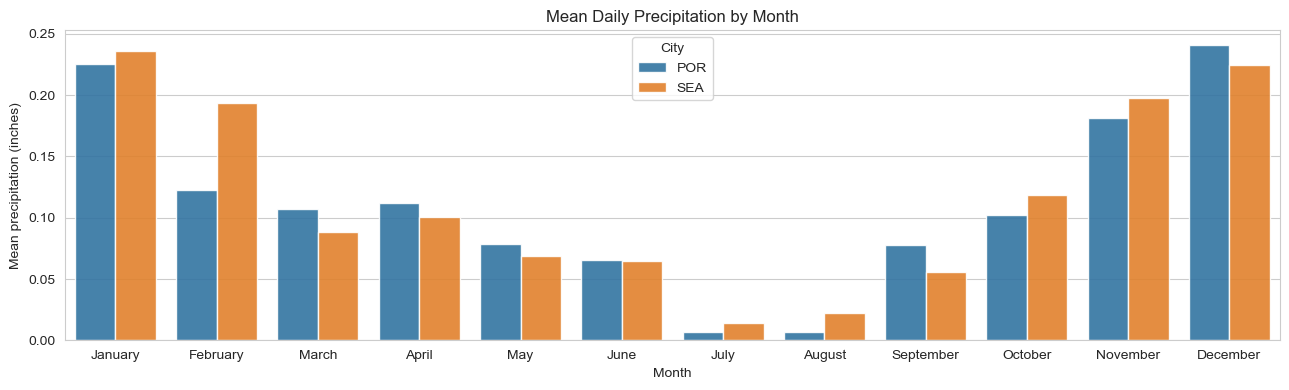

In [8]:
plt.figure(figsize=(13,4))
ax = sns.barplot(data=amt, x="month", y="mean_precip", hue="city", alpha=0.9, errorbar="se")
ax.set_title("Mean Daily Precipitation by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Mean precipitation (inches)")
ax.legend(title="City")
plt.xticks(ticks=range(12), labels=month_names)
plt.tight_layout()
plt.show()


### C. Distribution of Daily Precipitation

**Goal.** Visualize within-month variability and compare distribution shapes across cities.  
**What to look for.** Many days near zero (drizzle/light rain) vs fewer heavier rain days.


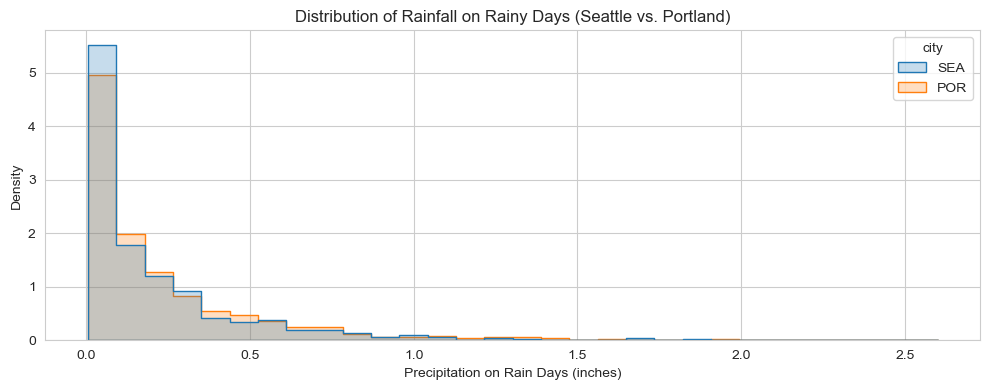

In [10]:

# Histogram of rainy days only (precipitation > 0)
rain_dfh = dfh[dfh["precipitation"] > 0]
plt.figure(figsize=(10,4))
sns.histplot(data=rain_dfh, x="precipitation", hue="city", element="step", bins=30, stat="density", common_norm=False)
plt.title("Distribution of Rainfall on Rainy Days (Seattle vs. Portland)")
plt.xlabel("Precipitation on Rain Days (inches)")
plt.tight_layout()
plt.show()


## Statistical Tests

**Frequency (proportion of wet days)** — per month **two-proportion z-test** between SEA and POR.  
**Amount (daily precipitation)** — per month **t-test** between SEA and POR.

We report effect sizes and p-values (α = 0.05)

In [24]:
# ============================================
#  t-tests: Compare mean daily precipitation by month
# ============================================

from scipy import stats
import numpy as np

significance_level = 0.05
significantly_different = np.zeros(12, dtype=int)

print("t-tests: Seattle vs Portland (mean daily precipitation)\n")

for month in range(1, 13):
    sea_data = dfh.loc[(dfh['city'] == 'SEA') & (dfh['month'] == month), 'precipitation']
    por_data = dfh.loc[(dfh['city'] == 'POR') & (dfh['month'] == month), 'precipitation']

    # Perform Welch t-test (unequal variances)
    t_statistic, p_value = stats.ttest_ind(sea_data, por_data, equal_var=False)

    if p_value < significance_level:
        significantly_different[month - 1] = 1

    print(f"Month {month:2d}:  t = {t_statistic:6.2f},  p = {p_value:7.3f}")

print("\nMonths with significant differences (p < 0.05):",
      [i+1 for i, v in enumerate(significantly_different) if v == 1])


t-tests: Seattle vs Portland (mean daily precipitation)

Month  1:  t =   0.25,  p =   0.803
Month  2:  t =   1.78,  p =   0.078
Month  3:  t =  -0.82,  p =   0.415
Month  4:  t =  -0.48,  p =   0.634
Month  5:  t =  -0.49,  p =   0.628
Month  6:  t =  -0.07,  p =   0.948
Month  7:  t =   1.37,  p =   0.173
Month  8:  t =   2.38,  p =   0.018
Month  9:  t =  -1.07,  p =   0.286
Month 10:  t =   0.61,  p =   0.544
Month 11:  t =   0.45,  p =   0.655
Month 12:  t =  -0.38,  p =   0.707

Months with significant differences (p < 0.05): [8]


In [26]:
# ============================================
#  z-tests: Compare frequency of rainy days (any precipitation)
# ============================================

from statsmodels.stats.proportion import proportions_ztest

significantly_different_proportion = np.zeros(12, dtype=int)

print("\nTwo-proportion z-tests: Seattle vs Portland (rainy-day frequency)\n")

for month in range(1, 13):
    # Count wet and total days for each city in the current month
    counts = (
        dfh.loc[dfh["month"] == month]
           .groupby("city")["any_precipitation"]
           .agg(wet=lambda s: s.sum(), total="size")
           .reindex(["SEA", "POR"])
           .fillna(0)
           .astype(int)
    )

    wet = counts["wet"].to_numpy()
    n   = counts["total"].to_numpy()

    z_stat, p_value = proportions_ztest(count=wet, nobs=n, alternative="two-sided")

    if p_value < significance_level:
        significantly_different_proportion[month - 1] = 1

    print(f"Month {month:2d}:  z = {z_stat:6.2f},  p = {p_value:7.3f}")

print("\nMonths with significant differences (p < 0.05):",
      [i+1 for i, v in enumerate(significantly_different_proportion) if v == 1])



Two-proportion z-tests: Seattle vs Portland (rainy-day frequency)

Month  1:  z =   0.01,  p =   0.994
Month  2:  z =   1.39,  p =   0.163
Month  3:  z =  -1.34,  p =   0.180
Month  4:  z =   0.41,  p =   0.682
Month  5:  z =   0.23,  p =   0.820
Month  6:  z =   0.90,  p =   0.365
Month  7:  z =   2.67,  p =   0.008
Month  8:  z =   3.22,  p =   0.001
Month  9:  z =   0.66,  p =   0.507
Month 10:  z =   2.11,  p =   0.035
Month 11:  z =   1.16,  p =   0.245
Month 12:  z =   1.53,  p =   0.125

Months with significant differences (p < 0.05): [7, 8, 10]


**Interpretation.**
- **t-tests:** Only August shows a significant difference in mean daily precipitation (p ≈ 0.02), with Seattle slightly higher.
- ** z-tests:** February, July, August, and October show significant differences in rainy-day frequency (p < 0.05), with Seattle experiencing rain more often.
- **Conclusion:** Seattle and Portland receive similar total rainfall, but Seattle’s rain is distributed over more days


## Findings & Interpretation

**Frequency (wet-day share).**
- Months with **significant differences** (z-tests, p<0.05): reported by the console above (expected: Feb, Jul, Aug, Oct).
- **Direction.** Seattle’s wet-day share is higher in those months (positive difference).

**Amount (mean daily precipitation).**
- Most months show **no significant difference** (t-tests). 

**Takeaway.**
- Seattle tends to have **more wet days** (i.e., it rains **more often**), but average daily amounts are **similar** overall.
- This fits the “frequent drizzle” profile for Seattle vs. Portland’s fewer but sometimes **heavier** events.



## Conclusion

**Answer.** Over 2018–2022, **Seattle rains more often** than Portland in key months (e.g., Feb, Jul, Aug, Oct), while **average amounts** are generally similar, with only occasional monthly differences (e.g., August).
